In [ ]:

# if you are running this on Google Colab then use this cell for data loading.
'''
from google.colab import files

uploaded = files.upload()

import io
df = pd.read_csv (io.BytesIO(uploaded['prices-split-adjusted.csv']))
df2 = pd.read_csv (io.BytesIO(uploaded['fundamentals.csv']))

'''

In [ ]:

# if you are running this on Kaggle's Kernel then use this cell for data loading.

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv("/kaggle/input/nyse/prices-split-adjusted.csv", index_col = 0)
df2 = pd.read_csv("/kaggle/input/nyse/fundamentals.csv")

'''

In [ ]:
# if you are running this on your local machine / PC then use this cell for data loading.
# import all stock prices 


df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df2 = pd.read_csv("fundamentals.csv")


In [5]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [6]:
# if you are running this on your local machine / PC then use this cell for data loading.

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [8]:
# Extract all the symbols from the list
symbols = list(set(df.symbol))
display(len(symbols))
display(symbols[:10])

501

['PEG', 'WFM', 'IR', 'MCO', 'ZTS', 'CMA', 'MAS', 'ILMN', 'D', 'EQT']

In [9]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,294.895159,299.886470,293.455551,300.499172,9483900.0


In [10]:
df.shape

(1762, 5)

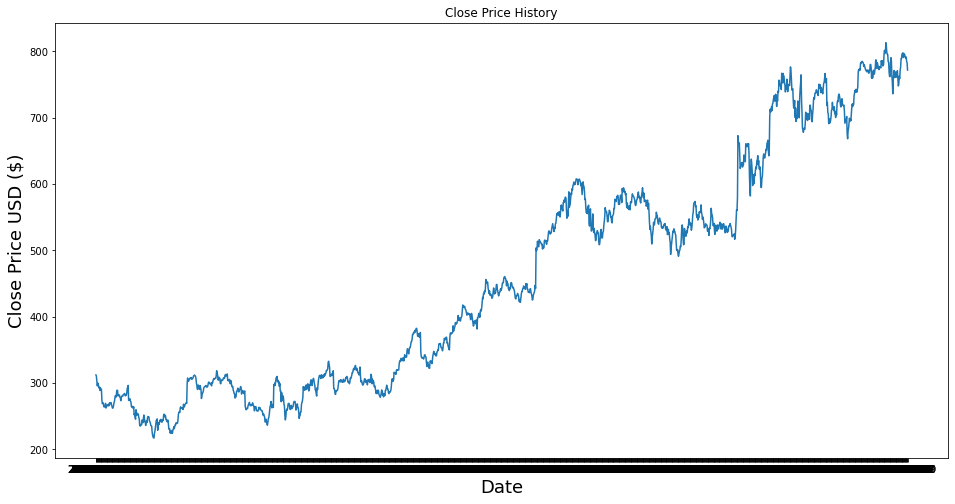

In [12]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [14]:
import math

#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [15]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [16]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [17]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [23]:
#Build the LSTM network 
model = Sequential() 

model.add(LSTM(units=512, return_sequences=True,input_shape=(x_train.shape[1],1))) 
model.add(Dropout(0.2))

model.add(LSTM(units=256, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(32,kernel_initializer="uniform",activation='relu'))

model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 512)           1052672   
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,848,385
Trainable params: 1,848,385
Non-trainable params: 0
____________________________________________

In [27]:
#Compile the model
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

In [29]:
model.fit(x_train,y_train,batch_size=32,epochs=100,validation_split=0.2,verbose=1)

Train on 1080 samples, validate on 270 samples
Epoch 1/100
1080/1080 [==============================] - 9s 9ms/step - loss: 0.0408 - accuracy: 9.2593e-04 - val_loss: 0.0936 - val_accuracy: 0.0000e+00
Epoch 2/100
1080/1080 [==============================] - 8s 8ms/step - loss: 0.0340 - accuracy: 9.2593e-04 - val_loss: 0.1210 - val_accuracy: 0.0000e+00
Epoch 3/100
1080/1080 [==============================] - 9s 8ms/step - loss: 0.0316 - accuracy: 9.2593e-04 - val_loss: 0.1081 - val_accuracy: 0.0000e+00
Epoch 4/100
1080/1080 [==============================] - 8s 8ms/step - loss: 0.0316 - accuracy: 9.2593e-04 - val_loss: 0.0915 - val_accuracy: 0.0000e+00
Epoch 5/100
1080/1080 [==============================] - 8s 8ms/step - loss: 0.0322 - accuracy: 9.2593e-04 - val_loss: 0.1099 - val_accuracy: 0.0000e+00
Epoch 6/100
1080/1080 [==============================] - 8s 7ms/step - loss: 0.0316 - accuracy: 9.2593e-04 - val_loss: 0.1068 - val_accuracy: 0.0000e+00
Epoch 7/100
1080/1080 [============

1080/1080 [==============================] - 8s 7ms/step - loss: 7.0573e-04 - accuracy: 9.2593e-04 - val_loss: 8.9348e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1080/1080 [==============================] - 8s 7ms/step - loss: 6.5767e-04 - accuracy: 9.2593e-04 - val_loss: 8.3042e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1080/1080 [==============================] - 9s 8ms/step - loss: 8.8370e-04 - accuracy: 9.2593e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 56/100
1080/1080 [==============================] - 8s 7ms/step - loss: 7.0013e-04 - accuracy: 9.2593e-04 - val_loss: 9.9116e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1080/1080 [==============================] - 8s 7ms/step - loss: 6.1757e-04 - accuracy: 9.2593e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 58/100
1080/1080 [==============================] - 8s 7ms/step - loss: 7.4489e-04 - accuracy: 9.2593e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 59/100
1080/1080 [=============================

In [30]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [31]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [32]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [33]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [34]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

86.9584907207842

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


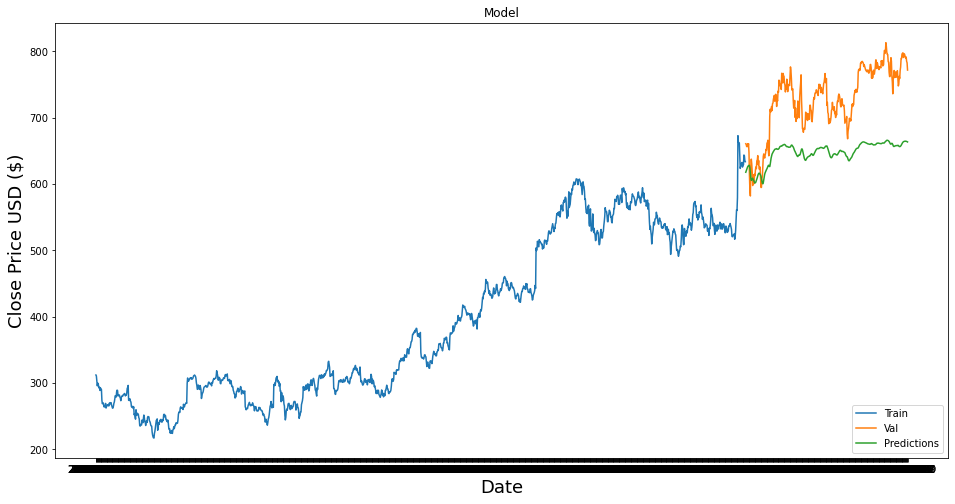

In [35]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [47]:
#Create a new dataframe
new_df = df.filter(['close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[662.634]]


In [45]:
# Cross-checking the predicted value with the real values.
# Get the quote
import pandas_datareader as web

google_quote = web.DataReader('GOOG', data_source='yahoo', start='2017-01-03', end='2017-01-03')
print(google_quote['Close'])

Date
2017-01-03    786.140015
Name: Close, dtype: float64
